In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [7]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/TP2-PF-management/48_Industry_Portfolios.CSV', header=6)
df = df.rename(columns={'Unnamed: 0': 'Date'})

df_48ind = df.iloc[:1171].copy()
df_48ind['Date'] = pd.to_datetime(df_48ind['Date'], format='%Y%m')
df_48ind.set_index('Date', inplace=True)
df_48ind = df_48ind.apply(pd.to_numeric, errors='coerce')
df_48ind.replace(-99.99, np.nan, inplace = True)
df_48ind.replace(-999, np.nan, inplace = True)
df_48ind.dropna(inplace = True)

df_numfirm = df.iloc[2564-20:3735-20].copy()
df_numfirm['Date'] = pd.to_datetime(df_numfirm['Date'], format='%Y%m')
df_numfirm.set_index('Date', inplace=True)
df_numfirm = df_numfirm.apply(pd.to_numeric, errors='coerce')

df_avgsize = df.iloc[3739-22:4910-22].copy()
df_avgsize['Date'] = pd.to_datetime(df_avgsize['Date'], format='%Y%m')
df_avgsize.set_index('Date', inplace=True)
df_avgsize = df_avgsize.apply(pd.to_numeric, errors='coerce')


market_cap = df_numfirm.multiply(df_avgsize, axis=0)
market_cap = market_cap.loc[df_48ind.index]


df_BtoM = df.iloc[4890:4988].copy()
df_BtoM = df_BtoM.apply(pd.to_numeric, errors='coerce')

df_BtoM = df_BtoM.loc[df_BtoM.index.repeat(12)].reset_index(drop=True)

df_BtoM['Date'] = pd.to_datetime(df_BtoM['Date'], format='%Y')

df_BtoM = df_BtoM.drop('Date', axis=1)

df_BtoM.replace(-99.99, np.nan, inplace = True)
df_BtoM.replace(-999, np.nan, inplace = True)
df_BtoM.dropna(inplace = True)

df_BtoM = pd.DataFrame(data = df_BtoM.iloc[5:].values, index = df_48ind.index, columns = df_48ind.columns)


df_mom = df_48ind.rolling(window=12).mean()

df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)


# Créer un objet StandardScaler
scaler = StandardScaler()

def standardize(df):
    # Standardiser les données
    df_scaled = scaler.fit_transform(df)
    
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    return df_standardized

standardized_market_caps = standardize(market_cap)
standardized_BtoM = standardize(df_BtoM)
standardized_mom = standardize(df_mom)

market_weights = market_cap.div(market_cap.sum(axis=1), axis=0)


standardized_market_caps = standardized_market_caps.loc[standardized_mom.index]
standardized_BtoM = standardized_BtoM.loc[standardized_mom.index]
standardized_mom = standardized_mom.loc[standardized_mom.index]
market_weights = market_weights.loc[standardized_mom.index]
df_48ind = df_48ind.loc[standardized_mom.index]

df4 = df_48ind.shift(-1).dropna()

standardized_market_caps = standardized_market_caps.loc[df4.index]
standardized_BtoM = standardized_BtoM.loc[df4.index]
standardized_mom = standardized_mom.loc[df4.index]
market_weights = market_weights.loc[df4.index]
df_48ind = df_48ind.loc[df4.index]

def calculate_regression_coefficients(N, returns, characteristic1, characteristic2, characteristic3):

    model = LinearRegression()

    beta_initial = []

    for i in range(N):
        y = returns.iloc[:, i]
        X1 = characteristic1.iloc[:, i]
        X2 = characteristic2.iloc[:, i]
        X3 = characteristic3.iloc[:, i]

        X_combined = pd.concat([X1, X2, X3], axis=1)

        model.fit(X_combined, y)
        beta_initial.append(model.coef_)

    return np.mean(beta_initial, axis=0)

coefficients_moyens = calculate_regression_coefficients(df_48ind.shape[1], df_48ind, standardized_market_caps, standardized_BtoM, standardized_mom)


def Expanding_window_optimization(MC, BM, MOM, r, gamma=5):
    
    def u(x, gamma=5):
        return (1+x) ** (1 - gamma) / (1 - gamma)

    def function_to_maximize(beta, MC, BM, MOM, r, T, N, gamma=5):
        wi_t = market_weights
        return -(1/T) * np.sum(u(np.sum((wi_t + (1/N) * (beta[0] * MC + beta[1] * BM + beta[2] * MOM)) * (r),axis=1), gamma))

    optimal_betas = {}  # Define optimal_betas here to store the optimal coefficients for each period
    
    start_year = df_48ind.index.min() # Date de début fixée à la première date dans les données de rendement
    
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01')
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    current_end_year = initial_end_year

    while current_end_year <= df_48ind.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        MC = standardized_market_caps.loc[start_year:current_end_year]
        BM = standardized_BtoM.loc[start_year:current_end_year]
        MOM = standardized_mom.loc[start_year:current_end_year]
        r = df_48ind.loc[start_year:current_end_year]
            
        N = df_48ind.shape[1]
        T = df_48ind.shape[0]

        # Initial guess for theta
        initial_beta = coefficients_moyens

        # Run the optimization for the current period
        result = minimize(function_to_maximize, initial_beta, args=( MC, BM, MOM, r, T, N, gamma), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_betas[current_end_year] = result.x if result.success else None
        
        optimal_weights = {}

        for end_year, betas in optimal_betas.items():
            # Calculer les poids optimaux pour chaque période
            weights = market_weights + (1 / len(market_weights.columns)) * (betas[0] * standardized_market_caps + betas[1] * standardized_BtoM + betas[2] * standardized_mom)
            optimal_weights[end_year] = weights

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_betas, optimal_weights


optimal_betas, optimal_weights = Expanding_window_optimization(standardized_market_caps, standardized_BtoM, standardized_mom, df_48ind)


In [3]:
coefficients_moyens

array([-0.34414125,  0.23074615,  1.91463923])

In [34]:
optimal_betas

{Timestamp('1973-12-01 00:00:00'): array([0.54599547, 0.57847012, 2.19381278]),
 Timestamp('1974-12-01 00:00:00'): array([0.48497228, 0.31111463, 2.24105786]),
 Timestamp('1975-12-01 00:00:00'): array([0.48950591, 0.29362763, 2.22556173]),
 Timestamp('1976-12-01 00:00:00'): array([ 557.48456433, -213.30949757,  -17.47141848]),
 Timestamp('1977-12-01 00:00:00'): array([ 557.48451874, -213.30940509,  -17.4714332 ]),
 Timestamp('1978-12-01 00:00:00'): array([ 557.48451517, -213.3094005 ,  -17.47143508]),
 Timestamp('1979-12-01 00:00:00'): array([ 557.48450548, -213.30938206,  -17.47143761]),
 Timestamp('1980-12-01 00:00:00'): array([ 557.48450545, -213.30938194,  -17.47143761]),
 Timestamp('1981-12-01 00:00:00'): array([ 557.48442055, -213.3092979 ,  -17.47150976]),
 Timestamp('1982-12-01 00:00:00'): array([ 557.48442869, -213.30931945,  -17.47149969]),
 Timestamp('1983-12-01 00:00:00'): array([ 557.48442836, -213.3093193 ,  -17.47149939]),
 Timestamp('1984-12-01 00:00:00'): array([ 557.4

In [31]:
optimal_weights

{Timestamp('1973-12-01 00:00:00'):                Agric     Food      Soda      Beer      Smoke     Toys   \
 Date                                                                     
 1970-06-01 -0.046708 -0.050118 -0.030707 -0.035804  0.007356 -0.094735   
 1970-07-01 -0.029550 -0.012186 -0.010523 -0.012869  0.025709 -0.060441   
 1970-08-01 -0.039856 -0.024689 -0.026033 -0.036985  0.018273 -0.051608   
 1970-09-01 -0.010835 -0.009791 -0.029474 -0.023539  0.010165 -0.044169   
 1970-10-01 -0.057089 -0.032823 -0.034995 -0.056228  0.005429 -0.061598   
 ...              ...       ...       ...       ...       ...       ...   
 2023-08-01 -0.035872 -0.005792  0.013834  0.004963 -0.001726 -0.003330   
 2023-09-01 -0.020044  0.001557  0.017050  0.003202  0.014774  0.010312   
 2023-10-01 -0.064010 -0.047102 -0.001998 -0.034220 -0.020614 -0.021851   
 2023-11-01 -0.075925 -0.045877 -0.008198 -0.034043 -0.023410 -0.024265   
 2023-12-01 -0.033729 -0.025636 -0.001273 -0.021388 -0.024565  0.0

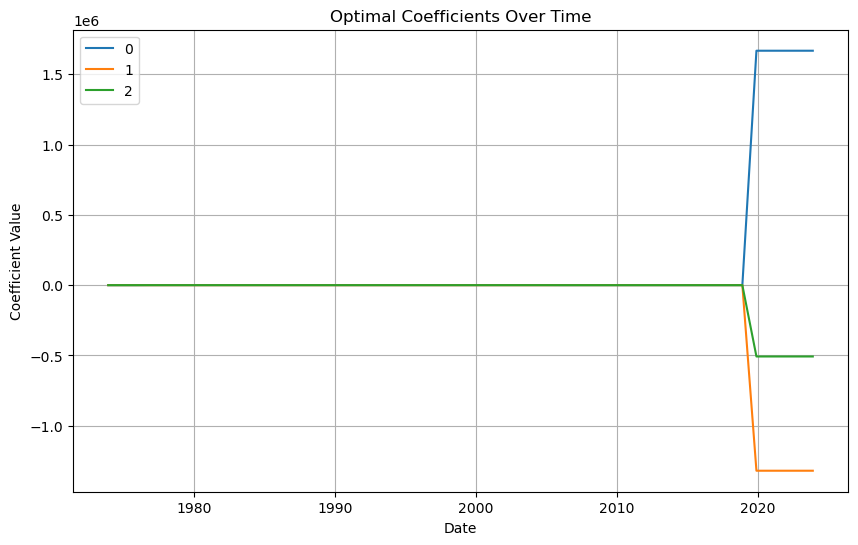

In [32]:
import matplotlib.pyplot as plt

# Convertir les résultats optimaux en DataFrame pour faciliter la manipulation
optimal_betas_df = pd.DataFrame(optimal_betas).T

# Tracer les coefficients optimaux
plt.figure(figsize=(10, 6))
for column in optimal_betas_df.columns:
    plt.plot(optimal_betas_df.index, optimal_betas_df[column], label=column)

plt.title('Optimal Coefficients Over Time')
plt.xlabel('Date')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/TP2-PF-management/48_Industry_Portfolios.CSV', header=6)
df = df.rename(columns={'Unnamed: 0': 'Date'})

df_48ind = df.iloc[:1171].copy()
df_48ind['Date'] = pd.to_datetime(df_48ind['Date'], format='%Y%m')
df_48ind.set_index('Date', inplace=True)
df_48ind = df_48ind.apply(pd.to_numeric, errors='coerce')
df_48ind.replace(-99.99, np.nan, inplace = True)
df_48ind.replace(-999, np.nan, inplace = True)
df_48ind.dropna(inplace = True)

df_numfirm = df.iloc[2564-20:3735-20].copy()
df_numfirm['Date'] = pd.to_datetime(df_numfirm['Date'], format='%Y%m')
df_numfirm.set_index('Date', inplace=True)
df_numfirm = df_numfirm.apply(pd.to_numeric, errors='coerce')

df_avgsize = df.iloc[3739-22:4910-22].copy()
df_avgsize['Date'] = pd.to_datetime(df_avgsize['Date'], format='%Y%m')
df_avgsize.set_index('Date', inplace=True)
df_avgsize = df_avgsize.apply(pd.to_numeric, errors='coerce')


market_cap = df_numfirm.multiply(df_avgsize, axis=0)
market_cap = market_cap.loc[df_48ind.index]


df_BtoM = df.iloc[4890:4988].copy()
df_BtoM = df_BtoM.apply(pd.to_numeric, errors='coerce')

df_BtoM = df_BtoM.loc[df_BtoM.index.repeat(12)].reset_index(drop=True)

df_BtoM['Date'] = pd.to_datetime(df_BtoM['Date'], format='%Y')

df_BtoM = df_BtoM.drop('Date', axis=1)

df_BtoM.replace(-99.99, np.nan, inplace = True)
df_BtoM.replace(-999, np.nan, inplace = True)
df_BtoM.dropna(inplace = True)

df_BtoM = pd.DataFrame(data = df_BtoM.iloc[5:].values, index = df_48ind.index, columns = df_48ind.columns)


df_mom = df_48ind.rolling(window=12).mean()

df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)


# Créer un objet StandardScaler
scaler = StandardScaler()

def standardize(df):
    # Standardiser les données
    df_scaled = scaler.fit_transform(df)
    
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    return df_standardized

standardized_market_caps = standardize(market_cap)
standardized_BtoM = standardize(df_BtoM)
standardized_mom = standardize(df_mom)

market_weights = market_cap.div(market_cap.sum(axis=1), axis=0)


standardized_market_caps = standardized_market_caps.loc[standardized_mom.index]
standardized_BtoM = standardized_BtoM.loc[standardized_mom.index]
standardized_mom = standardized_mom.loc[standardized_mom.index]
market_weights = market_weights.loc[standardized_mom.index]
df_48ind = df_48ind.loc[standardized_mom.index]

df4 = df_48ind.shift(-1).dropna()

standardized_market_caps = standardized_market_caps.loc[df4.index]
standardized_BtoM = standardized_BtoM.loc[df4.index]
standardized_mom = standardized_mom.loc[df4.index]
market_weights = market_weights.loc[df4.index]
df_48ind_ret = df_48ind.loc[df4.index]

def calculate_regression_coefficients(N, returns, characteristic1, characteristic2, characteristic3):

    model = LinearRegression()

    beta_initial = []

    for i in range(N):
        y = returns.iloc[:, i]
        X1 = characteristic1.iloc[:, i]
        X2 = characteristic2.iloc[:, i]
        X3 = characteristic3.iloc[:, i]

        X_combined = pd.concat([X1, X2, X3], axis=1)

        model.fit(X_combined, y)
        beta_initial.append(model.coef_)

    return np.mean(beta_initial, axis=0)

coefficients_moyens = calculate_regression_coefficients(df_48ind.shape[1], df_48ind_ret, standardized_market_caps, standardized_BtoM, standardized_mom)


def Expanding_window_optimization(MC, BM, MOM, r, gamma=5):
    
    def u(x, gamma=5):
        return (1+x) ** (1 - gamma) / (1 - gamma)

    def function_to_maximize(beta, MC, BM, MOM, r, T, N, gamma=5):
        wi_t = market_weights
        return -(1/T) * np.sum(u(np.sum((wi_t + (1/N) * (beta[0] * MC + beta[1] * BM + beta[2] * MOM)) * (r),axis=1), gamma))

    optimal_betas = {}  # Define optimal_betas here to store the optimal coefficients for each period
    
    start_year = df_48ind.index.min() # Date de début fixée à la première date dans les données de rendement
    
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01')
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    current_end_year = initial_end_year

    while current_end_year <= df_48ind.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        MC = standardized_market_caps.loc[start_year:current_end_year]
        BM = standardized_BtoM.loc[start_year:current_end_year]
        MOM = standardized_mom.loc[start_year:current_end_year]
        r = df_48ind.loc[start_year:current_end_year]
            
        N = df_48ind.shape[1]
        T = df_48ind.shape[0]

        # Initial guess for theta
        initial_beta = coefficients_moyens

        # Run the optimization for the current period
        result = minimize(function_to_maximize, initial_beta, args=( MC, BM, MOM, r, T, N, gamma), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_betas[current_end_year] = result.x if result.success else None
    
        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_betas


optimal_betas = Expanding_window_optimization(standardized_market_caps, standardized_BtoM, standardized_mom, df_48ind)



In [9]:
coefficients_moyens

array([-0.34414125,  0.23074615,  1.91463923])

In [72]:
optimal_betas_values = list(optimal_betas.values())
optimal_betas_values

df_test = pd.Series(optimal_betas_values).to_frame('Value')
df_test

,Value
0,"[0.5459954668857238, 0.5784701167283156, 2.193..."
1,"[0.48497227703023105, 0.31111463386691274, 2.2..."
2,"[0.48950590550923795, 0.293627632256901, 2.225..."
3,"[557.4845643269019, -213.30949756618762, -17.4..."
4,"[557.4845187426673, -213.30940509393784, -17.4..."
5,"[557.4845151675572, -213.3094005047957, -17.47..."
6,"[557.4845054846592, -213.30938205810597, -17.4..."
7,"[557.4845054548757, -213.3093819389028, -17.47..."
8,"[557.4844205547804, -213.30929789841704, -17.4..."
9,"[557.4844286915705, -213.3093194459677, -17.47..."


In [83]:
# Convertir le dictionnaire en DataFrame
df_test = pd.DataFrame.from_dict(optimal_betas, orient='index')

# Renommer les colonnes
df_test.columns = ['beta1', 'beta2', 'beta3']

df_test

,beta1,beta2,beta3
1973-12-01,5.459955e-01,5.784701e-01,2.193813
1974-12-01,4.849723e-01,3.111146e-01,2.241058
1975-12-01,4.895059e-01,2.936276e-01,2.225562
1976-12-01,5.574846e+02,-2.133095e+02,-17.471418
1977-12-01,5.574845e+02,-2.133094e+02,-17.471433
1978-12-01,5.574845e+02,-2.133094e+02,-17.471435
1979-12-01,5.574845e+02,-2.133094e+02,-17.471438
1980-12-01,5.574845e+02,-2.133094e+02,-17.471438
1981-12-01,5.574844e+02,-2.133093e+02,-17.471510
1982-12-01,5.574844e+02,-2.133093e+02,-17.471500


In [81]:
# Appeler la fonction Expanding_window_optimization
optimal_beta = Expanding_window_optimization(standardized_market_caps, standardized_BtoM, standardized_mom, df_48ind)

for i in range(len(market_weights)):
    beta1 = df_test.iloc[i, 0]  # Prend la valeur de la première colonne de la i-ème ligne de df_test
    beta2 = df_test.iloc[i, 1]  # Prend la valeur de la deuxième colonne de la i-ème ligne de df_test
    beta3 = df_test.iloc[i, 2]  # Prend la valeur de la troisième colonne de la i-ème ligne de df_test
    row_weights = market_weights.iloc[i, :] + (1 / len(market_weights.columns)) * (beta1 * standardized_market_caps.iloc[i, :] + beta2 * standardized_BtoM.iloc[i, :] + beta3 * standardized_mom.iloc[i, :])
    row_weights_df = pd.DataFrame(row_weights).T  # Convertir la série en DataFrame
    optimal_weights = optimal_weights.append(row_weights_df)

optimal_weights.columns = market_weights.columns
optimal_weights.index = market_weights.index

AttributeError: 'DataFrame' object has no attribute 'append'

In [84]:
# Appeler la fonction Expanding_window_optimization
optimal_beta = Expanding_window_optimization(standardized_market_caps, standardized_BtoM, standardized_mom, df_48ind)

optimal_weights = pd.DataFrame()

for i in range(len(market_weights)):
    beta1 = df_test.iloc[i, 0]  # Prend la valeur de la première colonne de la i-ème ligne de df_test
    beta2 = df_test.iloc[i, 1]  # Prend la valeur de la deuxième colonne de la i-ème ligne de df_test
    beta3 = df_test.iloc[i, 2]  # Prend la valeur de la troisième colonne de la i-ème ligne de df_test
    row_weights = market_weights.iloc[i, :] + (1 / len(market_weights.columns)) * (beta1 * standardized_market_caps.iloc[i, :] + beta2 * standardized_BtoM.iloc[i, :] + beta3 * standardized_mom.iloc[i, :])
    row_weights_df = pd.DataFrame(row_weights).T  # Convertir la série en DataFrame
    optimal_weights = pd.concat([optimal_weights, row_weights_df])

optimal_weights.columns = market_weights.columns
optimal_weights.index = market_weights.index

IndexError: index 51 is out of bounds for axis 0 with size 51

In [ ]:
row_weights = market_weights.iloc[i, :] + (1 / len(market_weights.columns)) * (beta1 * standardized_market_caps.iloc[i, :] + beta2 * standardized_BtoM.iloc[i, :] + beta3 * standardized_mom.iloc[i, :])

In [86]:
market_weights

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-06-01,0.000460,0.028814,0.012287,0.005949,0.007738,0.006018,0.003263,0.005133,0.085561,0.005786,...,0.018154,0.018205,0.003409,0.052092,0.005588,0.018704,0.010159,0.001798,0.016279,0.000126
1970-07-01,0.000618,0.030523,0.012310,0.006020,0.008416,0.006368,0.003540,0.005462,0.084660,0.006169,...,0.018282,0.016610,0.004056,0.053393,0.006016,0.021184,0.011817,0.001948,0.016744,0.000137
1970-08-01,0.000568,0.029986,0.012156,0.005991,0.008119,0.006687,0.003318,0.005772,0.082559,0.006217,...,0.018162,0.016776,0.003944,0.055195,0.005586,0.021040,0.012146,0.001964,0.017206,0.000127
1970-09-01,0.000542,0.028717,0.011420,0.005560,0.007744,0.007109,0.003277,0.005859,0.082139,0.006366,...,0.018643,0.017284,0.004015,0.055338,0.005721,0.021386,0.011765,0.001983,0.017315,0.000139
1970-10-01,0.000594,0.028779,0.011321,0.005534,0.007440,0.007211,0.003739,0.006007,0.083506,0.006803,...,0.017829,0.017990,0.004465,0.056529,0.006344,0.020271,0.012227,0.002179,0.017957,0.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.000995,0.011851,0.007773,0.008085,0.005243,0.000931,0.009142,0.000574,0.015286,0.005949,...,0.001740,0.019324,0.011698,0.074176,0.016307,0.061484,0.035742,0.001602,0.027401,0.026943
2023-09-01,0.000928,0.011433,0.007836,0.007835,0.005182,0.000942,0.008925,0.000620,0.015324,0.005710,...,0.001708,0.018376,0.011755,0.076022,0.015757,0.059433,0.035788,0.001558,0.027243,0.027591
2023-10-01,0.000986,0.011506,0.007677,0.007828,0.005236,0.000919,0.008347,0.000611,0.015038,0.005732,...,0.001748,0.018348,0.012045,0.075141,0.015854,0.060089,0.038577,0.001468,0.027638,0.028226


In [ ]:
def Expanding_window_optimization(MC, BM, MOM, r, gamma=5):
    
    def u(x, gamma=5):
        return (1+x) ** (1 - gamma) / (1 - gamma)

    def function_to_maximize(beta, MC, BM, MOM, r, T, N, gamma=5):
        wi_t = market_weights
        return -(1/T) * np.sum(u(np.sum((wi_t + (1/N) * (beta[0] * MC + beta[1] * BM + beta[2] * MOM)) * (r),axis=1), gamma))

    optimal_betas = {}  # Define optimal_betas here to store the optimal coefficients for each period
    
    start_year = df_48ind.index.min() # Date de début fixée à la première date dans les données de rendement
    
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01')
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    current_end_year = initial_end_year

    # Initial guess for theta
    initial_beta = coefficients_moyens

    while current_end_year <= df_48ind.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        MC = standardized_market_caps.loc[start_year:current_end_year]
        BM = standardized_BtoM.loc[start_year:current_end_year]
        MOM = standardized_mom.loc[start_year:current_end_year]
        r = df_48ind.loc[start_year:current_end_year]
            
        N = df_48ind.shape[1]
        T = df_48ind.shape[0]

        # Run the optimization for the current period
        result = minimize(function_to_maximize, initial_beta, args=( MC, BM, MOM, r, T, N, gamma), method='SLSQP')

        # Store the optimal theta for the current period
        if result.success:
            optimal_betas[current_end_year] = result.x
            initial_beta = result.x  # Update initial_beta with the optimal betas
        else:
            optimal_betas[current_end_year] = None
        
        optimal_weights = {}

        for end_year, betas in optimal_betas.items():
            # Calculer les poids optimaux pour chaque période
            weights = market_weights + (1 / len(market_weights.columns)) * (betas[0] * standardized_market_caps + betas[1] * standardized_BtoM + betas[2] * standardized_mom)
            optimal_weights[end_year] = weights

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_betas, optimal_weights